Results loaded successfully!
Models loaded successfully!
Data loaded successfully!

Evaluating DQN model...


DQN Evaluation: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.36s/it]



Evaluating PPO model...


PPO Evaluation: 100%|██████████████████████████████████████████████████████████████████| 20/20 [04:09<00:00, 12.50s/it]


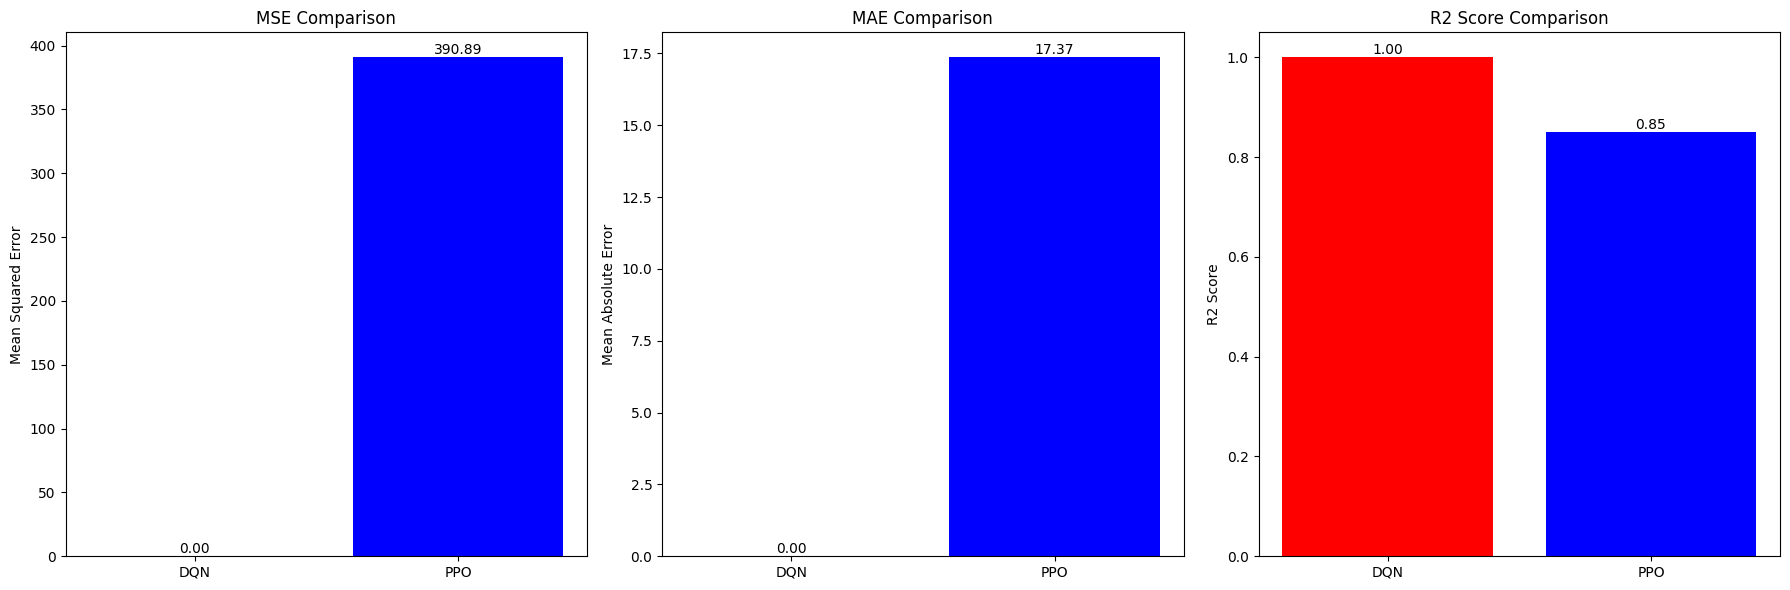


Model Comparison Results:
Metric    DQN            PPO            
MSE       0.0000         390.8906       
MAE       0.0000         17.3683        
R2        1.0000         0.8509         


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler  # Add this import
import seaborn as sns
from tqdm import tqdm

# Load saved results (update paths to your local files)
try:
    dqn_results = np.load('dqn_results.npy', allow_pickle=True).item()  # Local path
    ppo_results = np.load('ppo_results.npy', allow_pickle=True).item()  # Local path
    print("Results loaded successfully!")
except Exception as e:
    print(f"Could not load results: {e}\nMake sure you run both DQN and PPO models first and have the result files in your working directory.")

# Load models (update paths to your local files)
try:
    dqn_model = tf.keras.models.load_model('delivery_route_dqn.keras')  # Local path
    ppo_model = tf.keras.models.load_model('delivery_route_ppo.keras')  # Local path
    print("Models loaded successfully!")
except Exception as e:
    print(f"Could not load models: {e}\nMake sure you've trained and saved both models to your working directory.")

# Load data (update path to your local file)
file_path = 'amazon_delivery.csv'  # Local path
try:
    delivery_data = pd.read_csv(file_path)
    print("Data loaded successfully!")
except Exception as e:
    print(f"Could not load data: {e}\nMake sure the CSV file is in your working directory.")

# Preprocess
delivery_data_cleaned = delivery_data.drop(columns=["Order_ID", "Order_Date", "Order_Time", "Pickup_Time"])
categorical_columns = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
delivery_data_cleaned = pd.get_dummies(delivery_data_cleaned, columns=categorical_columns)
numeric_columns = ["Agent_Age", "Agent_Rating", "Store_Latitude", "Store_Longitude",
                   "Drop_Latitude", "Drop_Longitude", "Delivery_Time"]
delivery_data_cleaned[numeric_columns] = delivery_data_cleaned[numeric_columns].apply(pd.to_numeric)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    d_lat = np.radians(lat2 - lat1)
    d_lon = np.radians(lon2 - lon1)
    a = np.sin(d_lat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(d_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

delivery_data_cleaned["Distance"] = delivery_data_cleaned.apply(
    lambda row: haversine(row["Store_Latitude"], row["Store_Longitude"], row["Drop_Latitude"], row["Drop_Longitude"]),
    axis=1
)

# Drop unnecessary columns
delivery_data_cleaned.drop(columns=["Store_Latitude", "Store_Longitude", "Drop_Latitude", "Drop_Longitude"], inplace=True)

# Split data
X = delivery_data_cleaned.drop(columns=['Delivery_Time'])
y = delivery_data_cleaned['Delivery_Time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Optimized evaluation function
def evaluate_model(model, X, y, is_dqn=True, samples=20, sample_size=100):
    mse_values, mae_values, r2_values = [], [], []

    for _ in tqdm(range(samples), desc=f"{'DQN' if is_dqn else 'PPO'} Evaluation"):
        indices = np.random.choice(len(X), size=min(sample_size, len(X)), replace=False)
        X_sample = X.iloc[indices]
        y_sample = y.iloc[indices]

        predicted_times = []
        true_times = []

        for i in range(len(X_sample)):
            state = X_sample.iloc[i].values.astype(np.float32)
            true_time = y_sample.iloc[i]

            if is_dqn:
                action = np.argmax(model.predict(np.array([state]), verbose=0)[0])
            else:
                action_probs, _ = model.predict(np.array([state]), verbose=0)
                action = np.argmax(action_probs[0])

            action_time_effect = {0: 0.9, 1: 1.0, 2: 1.1, 3: 0.8, 4: 1.2}
            pred_time = true_time * action_time_effect.get(action, 1.0)

            predicted_times.append(pred_time)
            true_times.append(true_time)

        mse_values.append(mean_squared_error(true_times, predicted_times))
        mae_values.append(mean_absolute_error(true_times, predicted_times))
        r2_values.append(r2_score(true_times, predicted_times))

    return np.mean(mse_values), np.mean(mae_values), np.mean(r2_values)

# Evaluate models
print("\nEvaluating DQN model...")
dqn_mse, dqn_mae, dqn_r2 = evaluate_model(dqn_model, pd.DataFrame(X_test, columns=X.columns), y_test, is_dqn=True)

print("\nEvaluating PPO model...")
ppo_mse, ppo_mae, ppo_r2 = evaluate_model(ppo_model, pd.DataFrame(X_test, columns=X.columns), y_test, is_dqn=False)

# Plot results
model_names = ['DQN', 'PPO']
mse_values = [dqn_mse, ppo_mse]
mae_values = [dqn_mae, ppo_mae]
r2_values = [dqn_r2, ppo_r2]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MSE Comparison
axes[0].bar(model_names, mse_values, color=['red', 'blue'])
axes[0].set_title('MSE Comparison')
axes[0].set_ylabel('Mean Squared Error')
for i, v in enumerate(mse_values):
    axes[0].text(i, v, f"{v:.2f}", ha='center', va='bottom')

# MAE Comparison
axes[1].bar(model_names, mae_values, color=['red', 'blue'])
axes[1].set_title('MAE Comparison')
axes[1].set_ylabel('Mean Absolute Error')
for i, v in enumerate(mae_values):
    axes[1].text(i, v, f"{v:.2f}", ha='center', va='bottom')

# R2 Score Comparison
axes[2].bar(model_names, r2_values, color=['red', 'blue'])
axes[2].set_title('R2 Score Comparison')
axes[2].set_ylabel('R2 Score')
for i, v in enumerate(r2_values):
    axes[2].text(i, v, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print numerical results
print("\nModel Comparison Results:")
print(f"{'Metric':<10}{'DQN':<15}{'PPO':<15}")
print(f"{'MSE':<10}{dqn_mse:<15.4f}{ppo_mse:<15.4f}")
print(f"{'MAE':<10}{dqn_mae:<15.4f}{ppo_mae:<15.4f}")
print(f"{'R2':<10}{dqn_r2:<15.4f}{ppo_r2:<15.4f}")